In [15]:
#import libs
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
import random
#Model
import lightgbm as lgb
#BO
from bayes_opt import BayesianOptimization
#for random ensemble
from sklearn.linear_model import LogisticRegression
#evo alg
from deap import base, creator, tools, algorithms
#plot
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Common elements

In [16]:
STEP = 100
SEED = 42
CORRECT_FOR_INFLATION = True
UNDERSAMPLING = False

In [17]:
#dataset with added class label for b1, b2, c
df_data = pd.read_csv('../df_initial_comp3.csv')
df_data.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,class
0,29183981,2019-01-01,1,0,1,48,171,8304.31,42993.54,2501.04,...,8.0,0.0,-35773.32,2.33,5148.0,36602.13,54.0,0.0,5008.71,continua
1,29183981,2019-02-01,1,0,1,48,172,5263.49,44307.54,1145.41,...,8.0,0.0,-55114.90,43.34,5176.0,39468.25,49.0,0.0,4633.35,continua
2,29183981,2019-03-01,1,0,1,48,173,11046.11,52232.34,4303.03,...,11.0,0.0,-56200.22,19.90,5207.0,26117.65,44.0,0.0,3612.84,continua
3,29183981,2019-04-01,1,0,1,48,174,4804.61,54863.86,836.72,...,6.0,0.0,-37493.99,0.00,5237.0,39490.38,65.0,0.0,4304.91,continua
4,29183981,2019-05-01,1,0,1,48,175,0.00,0.00,0.00,...,9.0,0.0,-49427.69,2.33,5268.0,35927.92,54.0,0.0,4140.69,continua


In [18]:
def catastrophe_analysis(d):
    # Catastrophe Analysis
    # deben ir cosas de este estilo
    #   d[foto_mes == 202006, active_quarter := NA]
    d.loc[d['foto_mes'] == '2019-01-01', 'ctransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-01-01', 'mtransferencias_recibidas'] = np.nan

    d.loc[d['foto_mes'] == '2019-02-01', 'ctransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-02-01', 'mtransferencias_recibidas'] = np.nan

    d.loc[d['foto_mes'] == '2019-03-01', 'ctransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-03-01', 'mtransferencias_recibidas'] = np.nan

    d.loc[d['foto_mes'] == '2019-04-01', 'ctarjeta_visa_debitos_automaticos'] = np.nan
    d.loc[d['foto_mes'] == '2019-04-01', 'ctransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-04-01', 'mtransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-04-01', 'mttarjeta_visa_debitos_automaticos'] = np.nan
    d.loc[d['foto_mes'] == '2019-04-01', 'Visa_mfinanciacion_limite'] = np.nan

    d.loc[d['foto_mes'] == '2019-05-01', 'ccomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'ctarjeta_visa_debitos_automaticos'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'ctransferencias_recibidas'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mactivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mcomisiones'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mcomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mpasivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mrentabilidad_annual'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mrentabilidad'] = np.nan
    d.loc[d['foto_mes'] == '2019-05-01', 'mtransferencias_recibidas'] = np.nan

    d.loc[d['foto_mes'] == '2019-10-01', 'ccajeros_propios_descuentos'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'ccomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'chomebanking_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'ctarjeta_master_descuentos'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'ctarjeta_visa_descuentos'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mactivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mcajeros_propios_descuentos'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mcomisiones'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mcomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mpasivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mrentabilidad_annual'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mrentabilidad'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mtarjeta_master_descuentos'] = np.nan
    d.loc[d['foto_mes'] == '2019-10-01', 'mtarjeta_visa_descuentos'] = np.nan

    d.loc[d['foto_mes'] == '2020-01-01', 'cliente_vip'] = np.nan

    d.loc[d['foto_mes'] == '2020-06-01', 'active_quarter'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'catm_trx'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'catm_trx_other'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccajas_consultas'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccajas_depositos'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccajas_extracciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccajas_otras'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccajas_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccallcenter_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccheques_depositados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccheques_depositados_rechazados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccheques_emitidos'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccheques_emitidos_rechazados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ccomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'cextraccion_autoservicio'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'chomebanking_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'cmobile_app_trx'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ctarjeta_debito_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ctarjeta_master_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ctarjeta_visa_transacciones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'ctrx_quarter'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mactivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'matm'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'matm_other'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mautoservicio'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcheques_depositados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcheques_depositados_rechazados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcheques_emitidos'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcheques_emitidos_rechazados'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcomisiones'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcomisiones_otras'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mcuentas_saldo'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mextraccion_autoservicio'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mpasivos_margen'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mrentabilidad_annual'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mrentabilidad'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mtarjeta_master_consumo'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'mtarjeta_visa_consumo'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'tcallcenter'] = np.nan
    d.loc[d['foto_mes'] == '2020-06-01', 'thomebanking'] = np.nan
    return d

In [19]:
df_data = catastrophe_analysis(df_data)

In [20]:
#convert to polars
df_data = pl.from_pandas(df_data)
#convert date
df_data = df_data.with_columns(pl.col('foto_mes').str.to_date().alias('foto_mes'))

In [21]:
min_val_dict = (
    df_data.select(
        pl.col(pl.Int64).min()
    )
).to_dict()
max_val_dict = (
    df_data.select(
        pl.col(pl.Int64).max()
    )
).to_dict()

bool_cols = []

uint8_cols = []
uint16_cols = []
uint32_cols = []
uint64_cols = []

int8_cols = []
int16_cols = []
int32_cols = []
int64_cols = []

for k in min_val_dict.keys():
    if min_val_dict[k][0]==0 and max_val_dict[k][0]==1:
        bool_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=255:
        uint8_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=65535:
        uint16_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=4294967295:
        uint32_cols.append(k)
    elif min_val_dict[k][0]>=0:
        uint64_cols.append(k)
    elif min_val_dict[k][0]>=-128 and max_val_dict[k][0]<=127:
        int8_cols.append(k)
    elif min_val_dict[k][0]>=-32768 and max_val_dict[k][0]<=32767:
        int16_cols.append(k)
    elif min_val_dict[k][0]>=-2147483648 and max_val_dict[k][0]<=2147483647:
        int32_cols.append(k)
    else:
        print(f'Int64? {k}, min={min_val_dict[k][0]}, max={max_val_dict[k][0]}')
        int64_cols.append(k)

In [22]:
df_data = df_data.with_columns(
    [
        pl.col(pl.Float64).cast(pl.Float32),
        pl.col(bool_cols).cast(pl.UInt16),
        pl.col(uint8_cols).cast(pl.UInt16),
        pl.col(uint16_cols).cast(pl.UInt16),
        pl.col(uint32_cols).cast(pl.UInt32),
        pl.col(uint64_cols).cast(pl.UInt64),
        pl.col(int8_cols).cast(pl.Int16),
        pl.col(int16_cols).cast(pl.Int16),
        pl.col(int32_cols).cast(pl.Int32),
        pl.col(int64_cols).cast(pl.Int64),
    ]
)
print(df_data.estimated_size())

2826056919


In [23]:
#combine b1 and b2 classes
df_data = df_data.with_columns(df_data['class'].clone().alias('true_class'))
df_data = df_data.with_columns(
                                pl.when(df_data['true_class'] == 'Baja+2')\
                                .then(1)
                                .when(df_data['true_class'] == 'Baja+1')\
                                .then(0)\
                                .when(df_data['true_class'] == 'continua')\
                                .then(0)\
                                .otherwise(np.nan).alias('true_class')
                               )
df_data = df_data.with_columns(
                                pl.when(df_data['class'] == 'Baja+2')\
                                .then(1)
                                .when(df_data['class'] == 'Baja+1')\
                                .then(1)\
                                .when(df_data['class'] == 'continua')\
                                .then(0)\
                                .otherwise(np.nan).alias('class')
                               )

In [24]:
if CORRECT_FOR_INFLATION:
    foto_mes = df_data['foto_mes'].unique()
    #correct for inflation
    ipc = [189.6101, 
           196.7501, 
           205.9571, 
           213.0517, 
           219.5691, 
           25.537, 
           230.494, 
           239.6077, 
           253.7102, 
           262.0661,
           273.2158, 
           283.4442, 

           289.8299,
           295.666, 
           305.5515, 
           310.1243, 
           314.9087, 
           321.9738,
           328.2014, 
           337.0632, 
           346.6207,
           359.657,
           371.0211,
           385.8826, 

           401.5071, 
           415.8595, 
           435.8657, 
           453.6503, 
           468.725, 
           483.6049, 
           498.0987, 
           510.3942, 
           528.4968]

In [25]:
if CORRECT_FOR_INFLATION:
    df_ipc = pd.DataFrame(columns=['foto_mes','ipc'])
    df_ipc['foto_mes'] = foto_mes
    df_ipc['ipc'] = pd.Series(ipc) / 100
    df_ipc = pl.from_pandas(df_ipc)
    df_ipc =  df_ipc.with_columns(pl.col('foto_mes').map_elements(lambda dt: dt.date(), return_dtype=pl.Date).alias('foto_mes'))
    df_data = df_data.join(df_ipc, on='foto_mes')

In [26]:
if CORRECT_FOR_INFLATION:
    cols_pesos = ['mrentabilidad',
                 'mrentabilidad_annual',
                 'mcomisiones',
                 'mactivos_margen',
                 'mpasivos_margen',
                 'mcuenta_corriente_adicional',
                 'mcuenta_corriente',
                 'mcaja_ahorro',
                 'mcaja_ahorro_adicional',
                 'mcuentas_saldo',
                 'mautoservicio',
                 'mtarjeta_visa_consumo',
                 'mtarjeta_master_consumo',
                 'mprestamos_personales',
                 'mprestamos_prendarios',
                 'mprestamos_hipotecarios',
                 'mplazo_fijo_pesos',
                 'minversion1_pesos',
                 'minversion2',
                 'mpayroll',
                 'mpayroll2',
                 'mcuenta_debitos_automaticos',
                 'mttarjeta_visa_debitos_automaticos',
                 'mttarjeta_master_debitos_automaticos',
                 'mpagodeservicios',
                 'mpagomiscuentas',
                 'mcajeros_propios_descuentos',
                 'mtarjeta_visa_descuentos',
                 'mtarjeta_master_descuentos',
                 'mcomisiones_mantenimiento',
                 'mcomisiones_otras',
                 'mforex_buy',
                 'mforex_sell',
                 'mtransferencias_recibidas',
                 'mtransferencias_emitidas',
                 'mextraccion_autoservicio',
                 'mcheques_depositados',
                 'mcheques_emitidos',
                 'mcheques_depositados_rechazados',
                 'mcheques_emitidos_rechazados',
                 'matm',
                 'matm_other',
                 'Master_mfinanciacion_limite',
                 'Master_msaldototal',
                 'Master_msaldopesos',
                 'Master_mconsumospesos',
                 'Master_mlimitecompra',
                 'Master_madelantopesos',
                 'Master_mpagado',
                 'Master_mpagospesos',
                 'Master_mconsumototal',
                 'Master_mpagominimo',
                 'Visa_mfinanciacion_limite',
                 'Visa_msaldototal',
                 'Visa_msaldopesos',
                 'Visa_mconsumospesos',
                 'Visa_mlimitecompra',
                 'Visa_madelantopesos',
                 'Visa_mpagado',
                 'Visa_mpagospesos',
                 'Visa_mconsumototal',
                 'Visa_mpagominimo']

    for col in cols_pesos:
        df_data = df_data.with_columns((pl.col(col) / pl.col('ipc')).alias(col))
    df_data = df_data.drop('ipc')

In [27]:
#select all float colnames
#lag_columns = df_data.select([pl.col(pl.Float64)]).columns
lag_columns = df_data.select(pl.exclude(['numero_de_cliente',
                                         'foto_mes',
                                         'class',
                                         'true_class',
                                         'cliente_edad',
                                         'cliente_antiguedad'])).columns
    
#sort dataset
df_data = df_data.sort(["numero_de_cliente","foto_mes"], descending=[True, True])
    
#create lag features
for col in lag_columns:
    for i in [1,2,3]:
        lag_col_name = f"{col}_lag_{i}"
        df_data = df_data.with_columns(
                                        pl.col(col)
                                        .shift(-i)
                                        .over(pl.col('numero_de_cliente'))
                                        .alias(lag_col_name)
                                      )

In [28]:
#training and testing data
df_data = df_data.filter(df_data['foto_mes'] >= pl.date(2020,9,1))

In [29]:
#validation and test data
df_val = df_data.filter(df_data['foto_mes'] == pl.date(2021,7,1)).to_pandas()
df_test = df_data.filter(df_data['foto_mes'] == pl.date(2021,9,1)).to_pandas()

#undersampling
if UNDERSAMPLING:
    # Select all instances of class 1
    class_1_instances = df_data.filter(df_data['class'] == 1)

    # Select randomly chosen % of instances of class 0
    class_0_instances_sampled = df_data.filter(df_data['class'] == 0).sample(fraction=1, seed=SEED)

    # Concatenate the two datasets
    df_data_trim = pl.concat([class_1_instances, class_0_instances_sampled])
    #train data
    df_train = df_data_trim.filter(df_data_trim['foto_mes'] <= pl.date(2021,6,1)).to_pandas()
    
    del class_1_instances
    del class_0_instances_sampled
    del df_data_trim
else:
    df_train = df_data.filter(df_data['foto_mes'] <= pl.date(2021,6,1)).to_pandas()
    
#drop original data
del df_data

In [30]:
#deltas
for col in lag_columns:        
    last_col_name = col
    for i in [1,2,3]:
        lag_dif_col_name = f"{col}_dif_lag_{i}"
        df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
        df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
        df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
        last_col_name = f"{col}_lag_{i}"

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[lag_dif_col_name] = df_train[last_col_name] - df_train[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_val[lag_dif_col_name] = df_val[last_col_name] - df_val[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[lag_dif_col_name] = df_test[last_col_name] - df_test[f"{col}_lag_{i}"]
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\2633831580.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [31]:
#target function to maximize and curves
def calculate_expected_profit(df_labels, df_predictions, step, target_col, class_col, pos_val = 280000):
    assert len(df_labels['numero_de_cliente']) == len(df_predictions['numero_de_cliente'])
    curve = []
    max_value = 0
    max_step = -1
    df_comb = df_labels.merge(df_predictions, left_on='numero_de_cliente', right_on='numero_de_cliente')
    df_comb.sort_values(target_col, ascending=False, inplace=True)
    df_comb.reset_index(drop=True, inplace=True)
    for i in range(len(df_comb) // step + 1):
        curve.append((i,sum(df_comb[class_col].iloc[:min(i*step,len(df_comb))])*pos_val - min(i*step,len(df_comb)) * 7000))
        if max_value < sum(df_comb[class_col].iloc[:min(i*step,len(df_comb))])*pos_val - min(i*step,len(df_comb)) * 7000:
            max_value = sum(df_comb[class_col].iloc[:min(i*step,len(df_comb))])*pos_val - min(i*step,len(df_comb)) * 7000
            max_step = i
    return max_step, max_value, curve

In [32]:
# Custom metric function
def ganancia(preds, train_data):
    labels = train_data.get_label()
    metric_value = np.dot(preds, labels) * 280000 - np.sum(preds) * 7000
    return 'ganancia', metric_value, True

## BO model

In [50]:
#train 20 models
df_pred_val_single = df_val[['numero_de_cliente']]
df_pred_test_single = df_test[['numero_de_cliente']]

model = lgb.LGBMModel(
                           boosting= "gbdt",               
                           objective= "binary",
                           metric= "aucpr",
                           first_metric_only= True,
                           boost_from_average= True,
                           feature_pre_filter= False,
                           force_row_wise= True,           
                           verbosity= -1,
                           min_gain_to_split= 0.0,         
                           min_sum_hessian_in_leaf= 0.001,      

                           bagging_fraction= 1.0,          
                           pos_bagging_fraction= 1.0,      
                           neg_bagging_fraction= 1.0,      
                           scale_pos_weight= 2.0,          

                           drop_rate=  0.1,                
                           max_drop= 50,                   
                           skip_drop= 0.5,                 

                           extra_trees= False,              
                           max_depth=6,
                           n_estimators=1024,
                           colsample_bytree=0.76,
                           learning_rate=0.02, 
                           random_state=SEED,
    
                           reg_alpha=80,
                           reg_lambda=0.5,
                          )

#train
model.fit(
            df_train.drop(['numero_de_cliente','foto_mes','class','true_class','active_quarter'], axis=1), 
            df_train['class'],
            #eval_class_weight = df_train['class'].map(lambda x: class_weights[x]),
            #eval_metric = 'ganancia'
            eval_set=(df_val.drop(['numero_de_cliente',
                                                                'foto_mes',
                                                                'class',
                                                                'true_class','active_quarter'], axis=1),df_val['class'])
         )

#predict test
df_pred_val_single[f'prob_target'] = model.predict(df_val.drop(['numero_de_cliente',
                                                                'foto_mes',
                                                                'class',
                                                                'true_class','active_quarter'], axis=1))   

#predict test
df_pred_test_single[f'prob_target'] = model.predict(df_test.drop(['numero_de_cliente',
                                                                  'foto_mes',
                                                                  'class',
                                                                  'true_class','active_quarter'], axis=1))

C:\Users\blank\AppData\Local\Temp\ipykernel_16808\314140205.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_val_single[f'prob_target'] = model.predict(df_val.drop(['numero_de_cliente',
C:\Users\blank\AppData\Local\Temp\ipykernel_16808\314140205.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_test_single[f'prob_target'] = model.predict(df_test.drop(['numero_de_cliente',


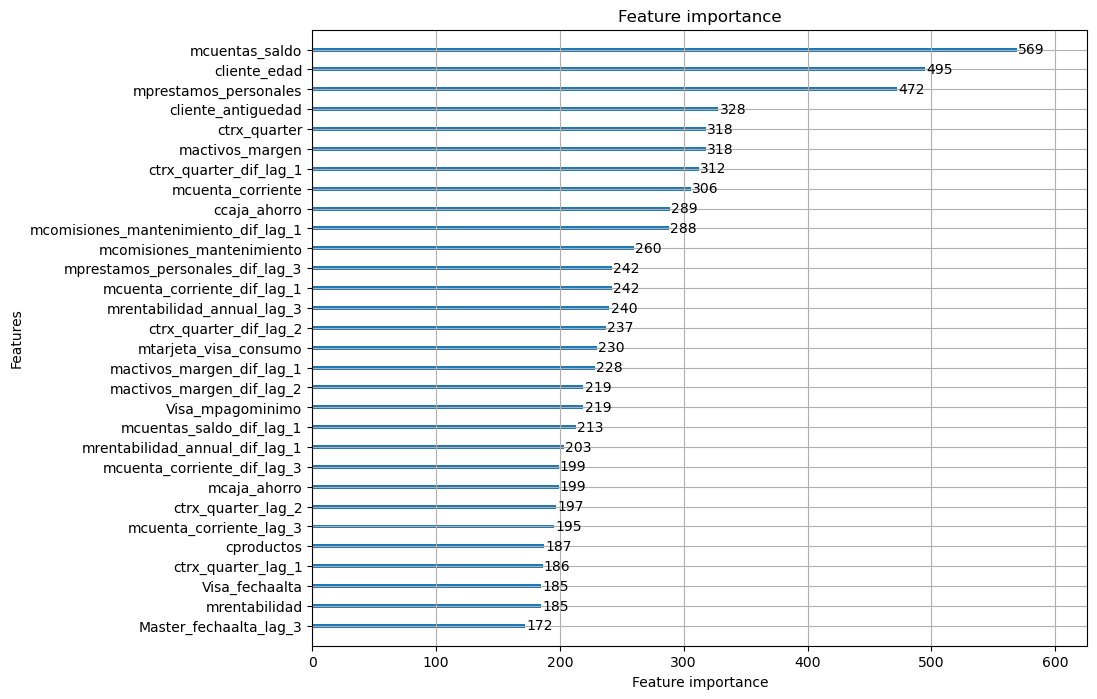

In [51]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 8), importance_type='split')
plt.show()

In [52]:
#Adjust number of sent
step, val, curve = calculate_expected_profit(df_labels=df_val[['numero_de_cliente','class']], 
                                             df_predictions=df_pred_val_single[['numero_de_cliente','prob_target']], 
                                             step=STEP,
                                             target_col='prob_target',class_col='class')
print('Single adjusted true labels', val, 'step', step)

Single adjusted true labels 410200000.0 step 180


In [53]:
#Adjust number of sent
step, val, curve = calculate_expected_profit(df_labels=df_val[['numero_de_cliente','true_class']], 
                                             df_predictions=df_pred_val_single[['numero_de_cliente','prob_target']], 
                                             step=STEP,
                                             target_col='prob_target',class_col='true_class')
print('Single adjusted true labels', val, 'step', step)

Single adjusted true labels 160160000.0 step 124


In [54]:
df_comb = df_val[['numero_de_cliente','true_class','class']].merge(df_pred_val_single[['numero_de_cliente','prob_target']],
                                                                   left_on='numero_de_cliente', right_on='numero_de_cliente')
df_comb.sort_values(['true_class','prob_target'], ascending=False, inplace=True)
df_comb.reset_index(drop=True, inplace=True)
df_comb

,numero_de_cliente,true_class,class,prob_target
0,112439143,1.0,1.0,0.955006
1,83342773,1.0,1.0,0.951824
2,89563662,1.0,1.0,0.894593
3,124314259,1.0,1.0,0.892324
4,125034654,1.0,1.0,0.886935
...,...,...,...,...
164677,114957298,0.0,0.0,0.000135
164678,78077267,0.0,0.0,0.000131
164679,89482022,0.0,0.0,0.000129
164680,80765071,0.0,0.0,0.000128


In [66]:
df_sub = df_pred_test_single.sort_values('prob_target',ascending=False)
df_sub.reset_index(drop=True, inplace=True)
df_sub.loc[:(step-5)*STEP,'prob_target'] = 1
df_sub.loc[(step-5)*STEP:,'prob_target'] = 0
df_sub['prob_target'] = df_sub['prob_target'].astype(bool)
df_sub.columns = ['numero_de_cliente','Predicted']
df_sub.to_csv(f'df_sub_{step}.csv',index=False)

In [60]:
df_sub = df_pred_test_single.sort_values('prob_target',ascending=False)

In [61]:
df_sub

,numero_de_cliente,prob_target
131653,57148324,0.953763
37837,121935465,0.950856
9555,157998525,0.948679
132567,56652840,0.946195
146492,39506624,0.941803
...,...,...
91184,80765071,0.000141
145642,39988906,0.000140
129435,58310941,0.000133
146157,39711160,0.000125
